In [215]:
from cleanlab import Datalab
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import polars as pl
import seaborn as sns
from matplotlib import pyplot as plt
from lib.MLP import BinaryTfidfMLPClassifier
from sklearn.model_selection import StratifiedKFold
from cleanlab.filter import find_label_issues
from sklearn.model_selection import StratifiedKFold
import numpy as np
from cleanlab.classification import CleanLearning

## Cleanlab
### Datalab Data Valuation
Cleanlab’s Shapely scores are transformed to lie between 0 and 1 such that: a score below 0.5 indicates a negative contribution to the model’s training performance, while a score above 0.5 indicates a positive contribution.

In [216]:
df = pl.read_csv("../data/labeled/19_06/to_classify.csv").to_pandas()

true_labels = df['label'].to_list()

vectorizer = TfidfVectorizer()

# Transform the text data into a feature matrix
X_vectorized = vectorizer.fit_transform(df['description_title_cats_compact'])

# Convert the sparse matrix to a dense matrix
X = X_vectorized.toarray()

In [217]:
lab = Datalab(data=df, label_name="label", task="classification")

# Perform data valuation
lab.find_issues(features=X, issue_types={"data_valuation": {}})

# Collect the identified issues
data_valuation_issues = lab.get_issues("data_valuation")

Finding data_valuation issues ...

Audit complete. 55 issues found in the dataset.


In [218]:
mask = data_valuation_issues["data_valuation_score"] < 0.5
original_indices = data_valuation_issues[mask].index.tolist()

# Add data valuation score to original df
df["data_valuation_score"] = data_valuation_issues["data_valuation_score"]

# Then filter
df.loc[original_indices].sort_values(by="data_valuation_score")[["data_valuation_score","label","description_title_cats_compact", "id_hash"]].iloc[:10]

,data_valuation_score,label,description_title_cats_compact,id_hash
120,0.497386,1,Förderung der selbstbestimmten Teilhabe von Me...,977e06d07074d61f892107592c378944
72,0.497549,1,Förderung von Forschungsvorhaben „Plattform Pr...,892750f7bab363532b99225c7886cd11
254,0.497712,1,Integrationsprojekte für Menschen mit Migratio...,6b4d125864be5f08e7819b80af8b5029
53,0.498039,1,ESF-Bundesprogramm – „rückenwind3 für Vielfalt...,83d023d6f250ed596d6dbc0aa3ce7ec7
7,0.498039,1,"Förderung von Projekten zur Inklusion, Partizi...",eda305464ae068152d4c084989b6a2ff
8,0.498366,1,Hamburger Partizipationsfonds (Förderbereich: ...,787895b92b2a20631d7053bb2aa7e2c4
121,0.498693,1,"Bürgerinnen und Bürger, Gleichstellung, Rechte...",7b228e2288ba3580d0aaac6df450b7f2
59,0.498693,1,Förderung von Kleinprojekten (Förderbereich: A...,122a5f6220d57c8614c593ea50188d31
128,0.498693,1,Umsetzung inklusiver Maßnahmen (RL Inklusion) ...,d72dc9bfe82d80f2fcb13cd6eafc39bc
235,0.498856,1,Förderung der Migrationsberatung in Niedersach...,2e9c664847c7be79bdd14975da44163e


In [219]:
data_val_hashes = df.loc[original_indices]["id_hash"].to_list()

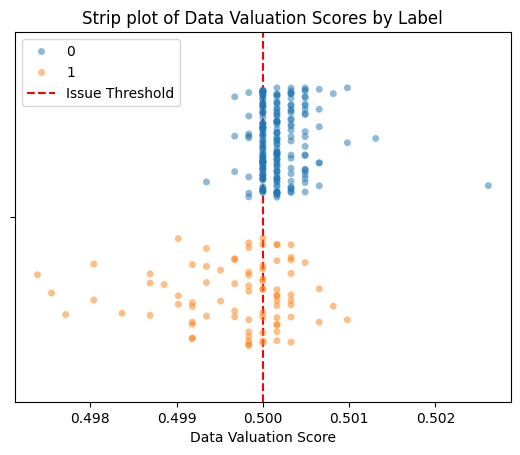

In [220]:
plot_data = (
    data_valuation_issues
    # Optionally, add a 'given_label' column to distinguish between labels in the histogram
    .join(pd.DataFrame({"given_label": df["label"]}))
)

# Plot strip plots of data valuation scores for each label
sns.stripplot(
    data=plot_data,
    x="data_valuation_score",
    hue="given_label",  # Comment out if no labels should be used in the visualization
    dodge=True,
    jitter=0.3,
    alpha=0.5,
)

plt.axvline(lab.info["data_valuation"]["threshold"], color="red", linestyle="--", label="Issue Threshold")

plt.title("Strip plot of Data Valuation Scores by Label")
plt.xlabel("Data Valuation Score")
plt.legend()
plt.show()

### Identify labeling issues with existing classifier

In [221]:
classifier = BinaryTfidfMLPClassifier.from_json('../models/tfidf_mlp_results_f1_0.7656.json')
cl = CleanLearning(classifier, cv_n_folds=5)

skf = StratifiedKFold(n_splits=5)
df = pl.read_csv("../data/labeled/19_06/to_classify.csv")
texts = df["description_title_cats_compact"].to_list()
true_labels = df["label"].to_list()

texts_array = np.array(texts)
labels_array = np.array(true_labels)

label_issues = cl.find_label_issues(
    texts_array,
    labels_array)

label_issues.head()

,is_label_issue,label_quality,given_label,predicted_label
0,False,0.872088,1,1
1,False,0.987286,1,1
2,False,0.993233,0,0
3,False,0.996835,0,0
4,True,0.093138,0,1


In [222]:
identified_issues = label_issues[label_issues["is_label_issue"] == True]
print(
    f"cleanlab found {len(identified_issues)} potential label errors in the dataset.\n"
)

cleanlab found 41 potential label errors in the dataset.



In [223]:
pdf = pd.DataFrame(
    {
        "text": texts,
        "quality": label_issues["label_quality"],
        "given_label": true_labels,
        "predicted_label": label_issues["predicted_label"],
    },
).sort_values(by="quality", ascending=True).iloc[:20]

print(pdf.to_string(
    max_colwidth=100,
    max_rows=None,
    max_cols=None,
    show_dimensions=True
))


                                                                                                    text   quality  given_label  predicted_label
72   Förderung von Forschungsvorhaben „Plattform Privatheit – IT-Sicherheit schützt Privatheit und st...  0.000137            1                0
202  Förderung modellhafter und innovativer Projektideen im Rahmen des Land.OpenData-Ideenwettbewerbs...  0.001453            1                0
277  Förderung der Kinder- und Jugendhilfe durch den Kinder- und Jugendplan des Bundes (KJP) (Förderb...  0.011432            0                1
82   Europäischer Sozialfonds Plus (ESF+) im Saarland (Förderbereich: Arbeit, Aus- & Weiterbildung, F...  0.011655            0                1
102  Förderung allgemeiner sozialer Maßnahmen wohlfahrtsverbandsunabhängiger Träger (Förderbereich: G...  0.012506            0                1
192  Migrationsberatung für erwachsene Zuwanderer (MBE) (Förderbereich: Gesundheit & Soziales; Förder...  0.013253            0   

In [224]:
pdf = pd.DataFrame(
    {
        "is_label_issue": label_issues["is_label_issue"],
        "id_hash" : df["id_hash"].to_list()
    },
)
label_issue_id_hashes = pdf[pdf["is_label_issue"] == True]["id_hash"].to_list()

### Combining metrics

In [225]:
# get intersection of data_val_hashes and label_issue_id_hashes
intersection = set(data_val_hashes).intersection(set(label_issue_id_hashes))
print(f"Intersection: {len(intersection)}")
# get union
union = set(data_val_hashes).union(set(label_issue_id_hashes))
print(f"Union: {len(union)}")
print(f"Data val hashes: {len(data_val_hashes)}")
print(f"Label issue id hashes: {len(label_issue_id_hashes)}")
                         

Intersection: 13
Union: 83
Data val hashes: 55
Label issue id hashes: 41


In [226]:
cdf = df.with_columns([
    pl.Series("data_valuation_score", data_valuation_issues["data_valuation_score"]),
    pl.Series("label_quality", label_issues["label_quality"]),
    pl.Series("is_label_issue", label_issues["is_label_issue"]),
    pl.Series("predicted_label", label_issues["predicted_label"])
])
cdf = cdf.with_columns([
    (pl.col("data_valuation_score") < 0.5).alias("is_detrimental"),
    (pl.col("predicted_label") != pl.col("label")).alias("label_mismatch")
])
# Create polars df with union hashes
cdf = cdf.filter(pl.col("id_hash").is_in(union))["id_hash", "url", "title", "description_html", "description_title_cats_compact", "data_valuation_score", "label_quality", "is_detrimental","is_label_issue", "predicted_label","label","label_mismatch"]
print(cdf.shape)
cdf.head()


(83, 12)


id_hash,url,title,description_html,description_title_cats_compact,data_valuation_score,label_quality,is_detrimental,is_label_issue,predicted_label,label,label_mismatch
str,str,str,str,str,f64,f64,bool,bool,i16,i64,bool
"""6f591d0a0cdb3ad8427f9d6461450b…","""https://www.foerderdatenbank.d…","""Erstorientierungskurse für Sch…","""<h3>Kurztext</h3> <p>Wenn Sie …","""Erstorientierungskurse für Sch…",0.499837,0.872088,true,false,1,1,false
"""9004f112d3f865010a2fa6ae3d8ac6…","""https://www.foerderdatenbank.d…","""Zusammenhalt durch Teilhabe""","""<h3>Kurztext</h3> <p>Wenn Sie …","""Zusammenhalt durch Teilhabe (F…",0.499837,0.987286,true,false,1,1,false
"""552a0ea7a1bb4c8c25f0962cfdf4b3…","""https://www.foerderdatenbank.d…","""Förderung familienentlastender…","""<h3>Kurztext</h3> <p>Wenn Sie …","""Förderung familienentlastender…",0.5,0.093138,false,true,1,0,true
"""eda305464ae068152d4c084989b6a2…","""https://www.foerderdatenbank.d…","""Förderung von Projekten zur In…","""<h3>Kurztext</h3> <p>Wenn Sie …","""Förderung von Projekten zur In…",0.498039,0.980574,true,false,1,1,false
"""787895b92b2a20631d7053bb2aa7e2…","""https://www.foerderdatenbank.d…","""Hamburger Partizipationsfonds""","""<h3>Kurztext</h3> <p>Wenn Sie …","""Hamburger Partizipationsfonds …",0.498366,0.433351,true,false,0,1,true


In [227]:
cdf.filter(
    (pl.col("is_detrimental") == True) & (pl.col("is_label_issue") == True)
)

id_hash,url,title,description_html,description_title_cats_compact,data_valuation_score,label_quality,is_detrimental,is_label_issue,predicted_label,label,label_mismatch
str,str,str,str,str,f64,f64,bool,bool,i16,i64,bool
"""bd07ff29e41ade5cfd3b329acbb7f0…","""https://www.foerderdatenbank.d…","""Förderung der Teilhabe und Unt…","""<h3>Kurztext</h3> <p>Wenn Sie …","""Förderung der Teilhabe und Unt…",0.499346,0.025244,true,true,1,0,true
"""1dcb85882697790942fd2a4a284827…","""https://www.foerderdatenbank.d…","""Zuwendungen im Rahmen des Asyl…","""<h3>Kurztext</h3> <p>Wenn Sie …","""Zuwendungen im Rahmen des Asyl…",0.499673,0.063271,true,true,1,0,true
"""cf0977d6f26f94db220e54baffb615…","""https://www.foerderdatenbank.d…","""Deutschkenntnisse und Sprachmi…","""<h3>Kurztext</h3> <p>Wenn Sie …","""Deutschkenntnisse und Sprachmi…",0.499837,0.021668,true,true,1,0,true
"""142a57177efca34e2216e6bf8ff862…","""https://www.foerderdatenbank.d…","""Förderung von Forschungsprojek…","""<h5>Rechtsgrundlage</h5> <p>Ri…","""Förderung von Forschungsprojek…",0.499183,0.056132,true,true,0,1,true
"""9ee45fc0247f47364782f66e48d4c8…","""https://www.foerderdatenbank.d…","""Förderung von Qualifizierungs-…","""<h3>Kurztext</h3> <p>Wenn Sie …","""Förderung von Qualifizierungs-…",0.499837,0.180389,true,true,1,0,true
…,…,…,…,…,…,…,…,…,…,…,…
"""67e0acac0b9837a91570ea83ea5b06…","""https://www.foerderdatenbank.d…","""Förderung modellhafter und inn…","""<h3>Kurztext</h3> <p>Wenn Sie …","""Förderung modellhafter und inn…",0.499183,0.001453,true,true,0,1,true
"""ce5fec13514752c0fa2666b786f656…","""https://www.foerderdatenbank.d…","""Förderung von Projekten zur Bi…","""<h3>Kurztext</h3> <p>Wenn Sie …","""Förderung von Projekten zur Bi…",0.499673,0.073531,true,true,1,0,true
"""567bc695c6dc1c12a9fdff787e0261…","""https://www.foerderdatenbank.d…","""Förderung von Projekten der Kr…","""<h3>Kurztext</h3> <p>Wenn Sie …","""Förderung von Projekten der Kr…",0.499837,0.082165,true,true,1,0,true


In [228]:
cdf.write_csv("../data/labeled/19_06/to_correct.csv")